Firs we import he necessary packages. We will be using tensorflow 2.x that has keras built in. We will do a classification task on fashion mnist, a dataset containing 60000+10000 images of clothes with the coresponding label (type of clothes)

In [5]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
print("version",tf.version)

version <module 'tensorflow._api.v2.version' from '/Users/hannesandersson/opt/anaconda3/lib/python3.9/site-packages/tensorflow/_api/v2/version/__init__.py'>


Next we download the data, the data is already split up into train and test sets. The $x$ values are the images, size $(28,28)$ and the $y$ values are the labels, $\{0,1,2,3,4,5,6,7,8,9\}$ corresponding to a certain type of clothes. Every pixel in the images takes a value between 0 and 255. It is often a good idea to scale the data between 0 and 1. We also add an extra dimension in both labels and images. This will make more sense when we work with CNN.

In [44]:
(x_train, y_train),(x_test,y_test) = fashion_mnist.load_data()
class_labels = ['T-shirt' ,'Trousers', 'Pullover', 'Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

x_train = x_train[:,:,:,np.newaxis]/255.
x_test = x_test[:,:,:,np.newaxis]/255.

y_train = y_train[:,np.newaxis]
y_test = y_test[:,np.newaxis]

9


Lets visualize the images

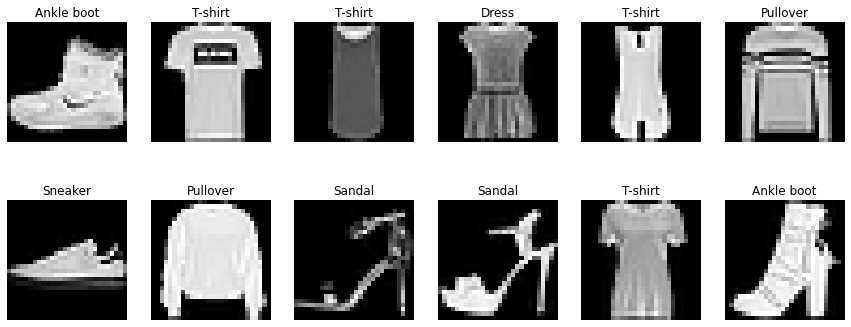

In [34]:
plt.figure(figsize=(15,6))
for i in range(12):
    plt.subplot(2,6,i+1)
    plt.imshow(x_train[i].reshape((28,28)),cmap = "gray")
    plt.title(class_labels[y_train[i,0]])
    plt.axis('off')

Now lets build our NN! I will be using keras functional API (https://keras.io/guides/functional_api/), you are ofcourse free to use the sequential API (https://keras.io/api/models/sequential/). 
Our first model will be a linear model, always good to start with a small model first and then build up.

We do this by first specifying the Input layer, this creates an input node that we can feed data.
Then we flatten the data, this can of course be done in the data preprocessing instead. 
Then we create a Dense layer, simply a fully connected layer, with 10 outputs, 1 for each class. The activation will be softmax so that we can think of the output as a probability vector over the labels. We then feed that layer with the outputs of the previous layer, in this case the flattened inputs

We create a model by simply telling were we feed data and what is our outputs. 
Now we are ready to compile the model by specifying the optimizer, loss function and what metrics we would like to see. Here accuracy measn that we will during training not only see the loss go down but also hopefully the accuracy go upp.

As our loss we chose the categorical cross-entropy. This can be seen as the negative log-likelihood of a categorical distribution, where our output of the NN is seen as the probability of each class. Sparse means that the labels are in the form $1,3,5,7...$ instead of one-hot encoded.

In [9]:
inputs = Input(shape = (28,28,1))
fl = Flatten()(inputs)
outputs = Dense(10, activation = 'softmax')(fl)

model = Model(inputs, outputs,name = "linear_model")
opt = SGD(learning_rate = 0.01)
model.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

We can inspect the model by calling the summary function, we see that we have almost 8000 parameters to train.

In [10]:
model.summary()

Model: "linear_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


Now lets train our model! This is done by calling the fit function on our model. We set the training and test data, how big our batch size is and how many epochs we like our model to run.

In [11]:
training_hist = model.fit(x_train, y_train, batch_size = 32, epochs = 30, validation_data=(x_test,y_test))

Epoch 1/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.8202 - accuracy: 0.7389 - val_loss: 0.6523 - val_accuracy: 0.7832
Epoch 2/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5915 - accuracy: 0.8070 - val_loss: 0.5822 - val_accuracy: 0.8043
Epoch 3/30
1875/1875 [==============================] - 5s 2ms/step - loss: 0.5424 - accuracy: 0.8214 - val_loss: 0.5507 - val_accuracy: 0.8145
Epoch 4/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5156 - accuracy: 0.8287 - val_loss: 0.5306 - val_accuracy: 0.8202
Epoch 5/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4981 - accuracy: 0.8331 - val_loss: 0.5186 - val_accuracy: 0.8229
Epoch 6/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4851 - accuracy: 0.8373 - val_loss: 0.5100 - val_accuracy: 0.8267
Epoch 7/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4757 - accuracy: 0.8395 - val_loss: 0.5021 - val_accuracy:

We see that we get a training accuracy of about 86% and a training accuracy of about 84%. Lets plot the loss and accuracy for the test and training data. The gap between the test and training data is the overfitting gap. 

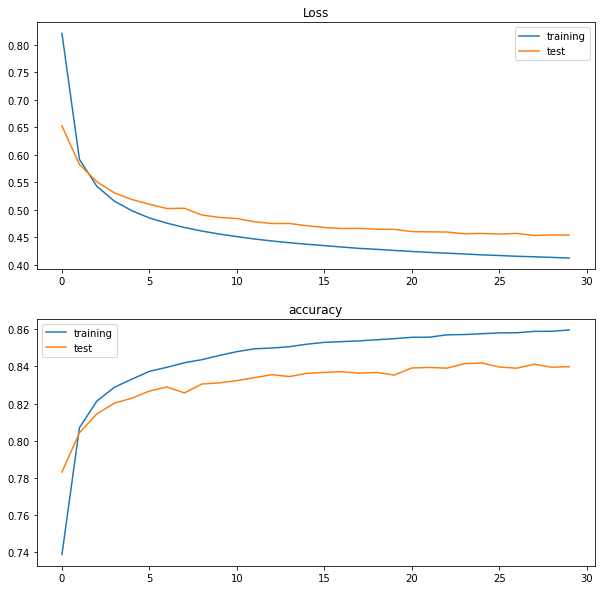

In [12]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(training_hist.history['loss'])
plt.plot(training_hist.history['val_loss'])
plt.title('Loss')
plt.legend(['training','test'])
plt.subplot(2,1,2)
plt.plot(training_hist.history['accuracy'])
plt.plot(training_hist.history['val_accuracy'])
plt.title('accuracy')
plt.legend(['training','test'])

Lets try to improve the model. Let build a deep model. We do this naivly by stacking Dense layers on top of each other, called the hidden layers. Lets do a 4 hidden layers model with relu activation. We also choose a fancier optimization algorithm

In [88]:
inputs_deep = Input(shape = (28,28,1))
fl = Flatten()(inputs_deep)
hidden_1 = Dense(1000,activation = 'relu')(fl)
hidden_2 = Dense(500, activation = 'relu')(hidden_1)
hidden_3 = Dense(100, activation = 'relu')(hidden_2)
hidden_4 = Dense(50, activation = 'relu')(hidden_3)
outputs_deep = Dense(10, activation = 'softmax')(hidden_4)

model_deep = Model(inputs_deep, outputs_deep,name = "dense_deep")
opt = Adam()
model_deep.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

The number of parameters grow quickly and now we have around 1.3 million parameters to train.

In [89]:
model_deep.summary()

Model: "dense_deep"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 1000)              785000    
_________________________________________________________________
dense_42 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_43 (Dense)             (None, 100)               50100     
_________________________________________________________________
dense_44 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_45 (Dense)             (None, 10)                5

In [90]:
training_hist_deep = model_deep.fit(x_train, y_train, batch_size = 32, epochs = 50, validation_data=(x_test,y_test))

Epoch 1/50
1875/1875 [==============================] - 20s 11ms/step - loss: 0.4953 - accuracy: 0.8222 - val_loss: 0.4121 - val_accuracy: 0.8486
Epoch 2/50
1875/1875 [==============================] - 19s 10ms/step - loss: 0.3728 - accuracy: 0.8635 - val_loss: 0.3939 - val_accuracy: 0.8595
Epoch 3/50
1875/1875 [==============================] - 19s 10ms/step - loss: 0.3311 - accuracy: 0.8791 - val_loss: 0.3542 - val_accuracy: 0.8734
Epoch 4/50
1875/1875 [==============================] - 20s 10ms/step - loss: 0.3089 - accuracy: 0.8861 - val_loss: 0.3492 - val_accuracy: 0.8747
Epoch 5/50
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2894 - accuracy: 0.8927 - val_loss: 0.3624 - val_accuracy: 0.8762
Epoch 6/50
1875/1875 [==============================] - 22s 12ms/step - loss: 0.2757 - accuracy: 0.8964 - val_loss: 0.3424 - val_accuracy: 0.8815
Epoch 7/50
1875/1875 [==============================] - 23s 12ms/step - loss: 0.2613 - accuracy: 0.9031 - val_loss: 0.3629 -

We can save the model with tf.keras.models.save_model() and load with tf.keras.models.load_model(). That way we dont have to retrain larger models.

In [95]:
tf.keras.models.save_model(model_deep,'model_deep.h5')

In [168]:
model_loaded = tf.keras.models.load_model('model_deep.h5')

This more powerfull model performs much better on the training set with an training accuracy of almost 97%. This comes at the expense of hevily overfitting. In the plots below we see while the training error goes down, the test error goes up. We become over confident on the training set. Our test accuracy aslo hasnt improved from 89% so quite a big overfitting gap. Still our test accuracy is higher than in the linear model

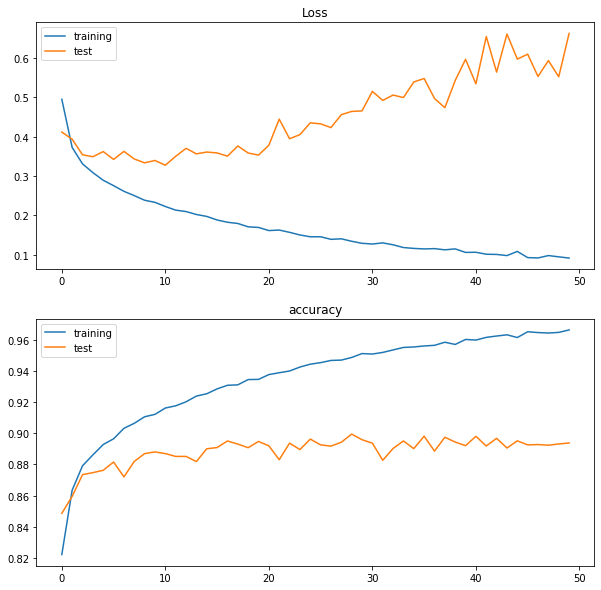

In [96]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(training_hist_deep.history['loss'])
plt.plot(training_hist_deep.history['val_loss'])
plt.title('Loss')
plt.legend(['training','test'])
plt.subplot(2,1,2)
plt.plot(training_hist_deep.history['accuracy'])
plt.plot(training_hist_deep.history['val_accuracy'])
plt.title('accuracy')
plt.legend(['training','test'])

Lets combat this overfitting with some fancy methods. Instead of dense layers we use convolutional layers. CNN can be seen as $k\times k$ filter that slides over the image and picks up a certain pattern. You can alsoo see it as a restriction of dense layers where everty node is not connected to every node and a lot of the edges share the same weights. This means less expressive power but hopefully it generalizes better.

We also use maxpooling which is a layer with no trainable parameters. It can be seen as a filter that slides over the images and picks up the "interesting parts". in maxpooling that is the pixel with the highest value. In the end we have a dense layer that maps to the output.

We also add dropout, a dropout layer with parameter p, here 0.1, means that the we drop the corresponding value with probability 0.1. So when passing inputs through a dropout layer only 90% will be unaffected and the rest will be zero. This helps with generalization because it is harder for the network to memorize the data.

In [124]:
inputs_cnn = Input(shape = (28,28,1))
cnn_1 = Conv2D(filters = 8, padding='same',kernel_size = 3, strides = (1,1),activation = 'relu')(inputs_cnn)
dr_1 = Dropout(0.1)(cnn_1)
cnn_2 = Conv2D(filters = 8, padding='same',kernel_size = 3, strides = (1,1),activation = 'relu')(dr_1)
mp_1 = MaxPool2D(pool_size= 2)(cnn_2)
dr_2 = Dropout(0.1)(mp_1)


cnn_3 = Conv2D(filters = 16, padding='same',kernel_size = 3, strides = (1,1),activation = 'relu')(dr_2)
dr_3 = Dropout(0.1)(cnn_3)
cnn_4 = Conv2D(filters = 16, padding='same',kernel_size = 3, strides = (1,1),activation = 'relu')(dr_3)
mp_2 = MaxPool2D(pool_size= 2)(cnn_4)
dr_4 = Dropout(0.1)(mp_2)

cnn_5 = Conv2D(filters = 32, padding='same',kernel_size = 3, strides = (1,1),activation = 'relu')(dr_4)
dr_5 = Dropout(0.1)(cnn_5)
cnn_6 = Conv2D(filters = 32, padding='same',kernel_size = 3, strides = (1,1),activation = 'relu')(dr_5)
mp_3 = MaxPool2D(pool_size= 2)(cnn_6) 

fl= Flatten()(mp_3)
output_cnn = Dense(10, activation = 'softmax')(fl)

model_cnn = Model(inputs_cnn, output_cnn)
opt = Adam()
model_cnn.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

This model has way fewer parameters, only around 21.000

In [125]:
model_cnn.summary()

Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 28, 28, 8)         80        
_________________________________________________________________
dropout_10 (Dropout)         (None, 28, 28, 8)         0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 28, 28, 8)         584       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 14, 14, 8)         0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 14, 14, 16)      

In [126]:
training_hist_cnn = model_cnn.fit(x_train, y_train, batch_size = 32, epochs = 50, validation_data=(x_test,y_test))

Epoch 1/50
1875/1875 [==============================] - 44s 24ms/step - loss: 0.5879 - accuracy: 0.7826 - val_loss: 0.4254 - val_accuracy: 0.8429
Epoch 2/50
1875/1875 [==============================] - 44s 24ms/step - loss: 0.3992 - accuracy: 0.8517 - val_loss: 0.3544 - val_accuracy: 0.8713
Epoch 3/50
1875/1875 [==============================] - 45s 24ms/step - loss: 0.3471 - accuracy: 0.8708 - val_loss: 0.3396 - val_accuracy: 0.8716
Epoch 4/50
1875/1875 [==============================] - 45s 24ms/step - loss: 0.3205 - accuracy: 0.8811 - val_loss: 0.3022 - val_accuracy: 0.8871
Epoch 5/50
1875/1875 [==============================] - 45s 24ms/step - loss: 0.2999 - accuracy: 0.8874 - val_loss: 0.2840 - val_accuracy: 0.8944
Epoch 6/50
1875/1875 [==============================] - 45s 24ms/step - loss: 0.2844 - accuracy: 0.8945 - val_loss: 0.2837 - val_accuracy: 0.8969
Epoch 7/50
1875/1875 [==============================] - 45s 24ms/step - loss: 0.2744 - accuracy: 0.8974 - val_loss: 0.2592 -

In [127]:
tf.keras.models.save_model(model_cnn,'model_cnn.h5')

We get a little bit better results with a test accuracy of 91.5%. We dont get as high training accuracy but that is expected when you have dropout.

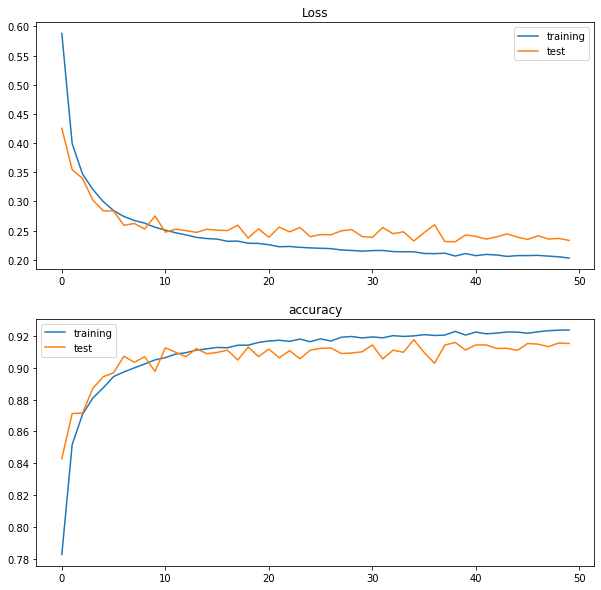

In [128]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(training_hist_cnn.history['loss'])
plt.plot(training_hist_cnn.history['val_loss'])
plt.title('Loss')
plt.legend(['training','test'])
plt.subplot(2,1,2)
plt.plot(training_hist_cnn.history['accuracy'])
plt.plot(training_hist_cnn.history['val_accuracy'])
plt.title('accuracy')
plt.legend(['training','test'])

Lets inspect the result. First we look at some random test images and look at the predictions. 

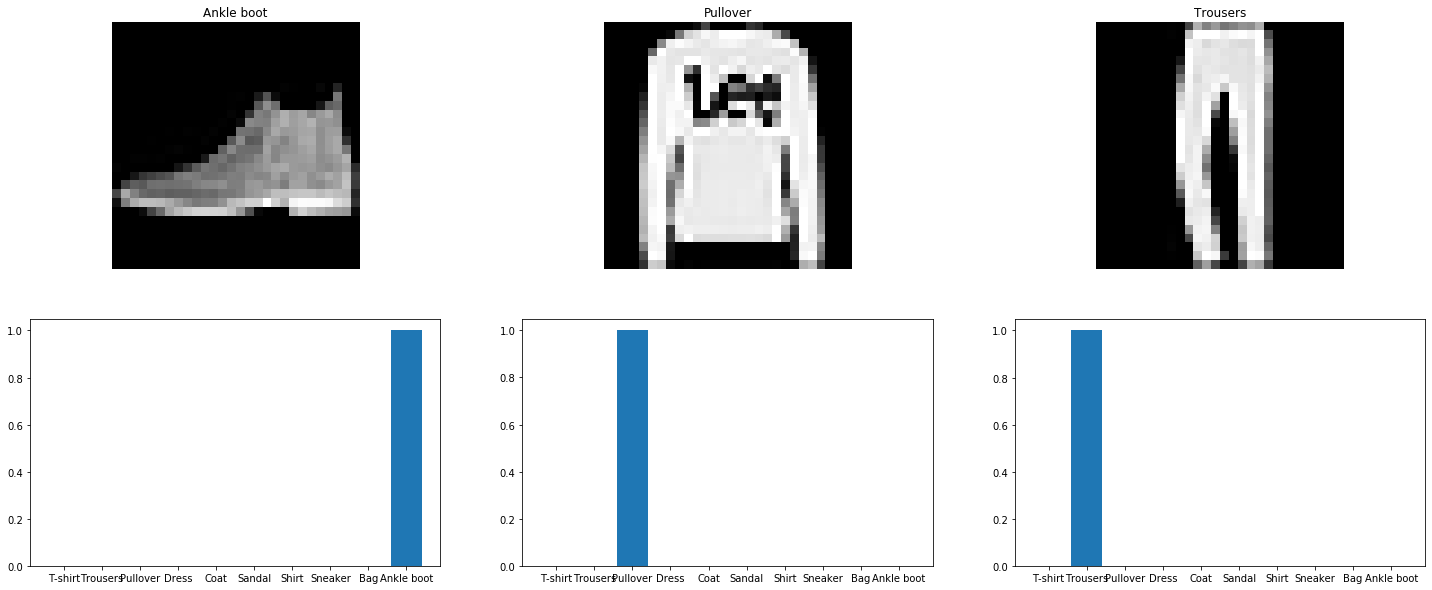

In [138]:
y_pred = model_cnn.predict(x_test[0:3])
plt.figure(figsize= (25,10))
for i in range(3):
    plt.subplot(2,3,i+1)
    plt.imshow(x_test[i].reshape((28,28)),cmap='gray')
    plt.title(class_labels[y_test[i,0]])
    plt.axis('off')
    plt.subplot(2,3,i+4)
    plt.bar(class_labels,y_pred[i])

Lets look at some examples where the model guesses wrong

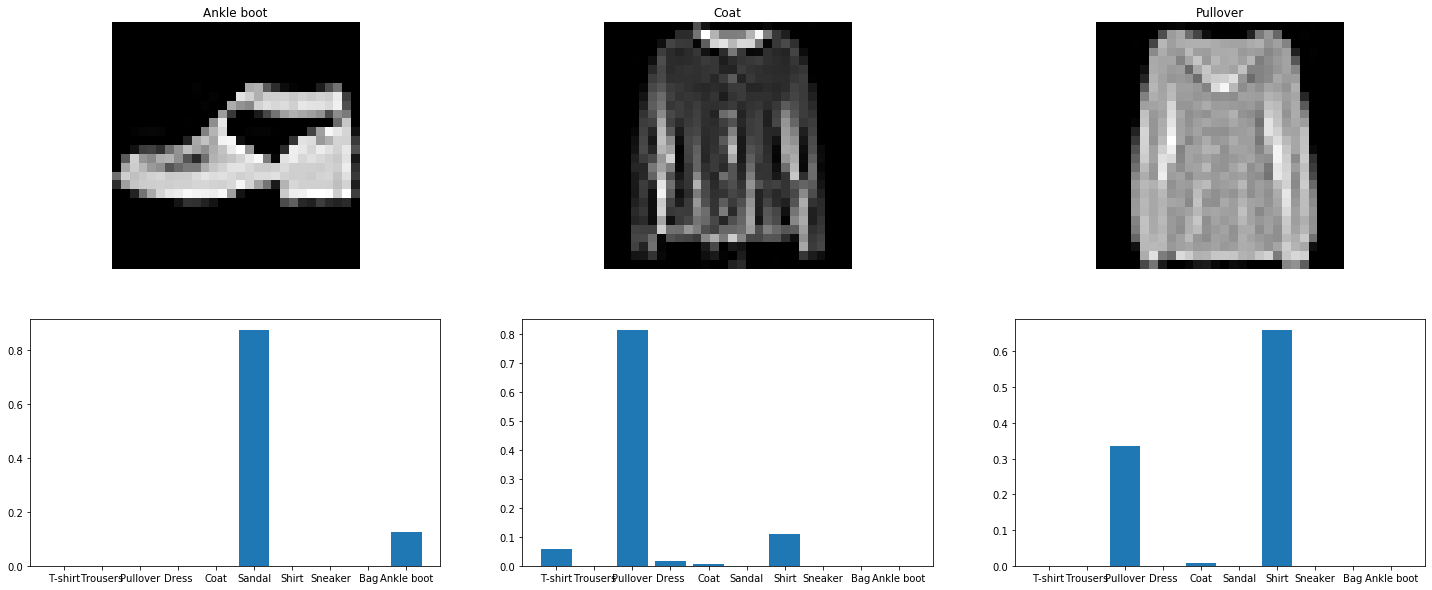

In [165]:
y_pred = model_cnn.predict(x_test[0:1000])
wrong = np.argmax(y_pred,axis = 1) != y_test[0:1000,0]
y_pred_wrong = y_pred[wrong]
y_test_wrong = y_test[0:1000][wrong]
x_test_wrong = x_test[0:1000][wrong]
plt.figure(figsize= (25,10))
for i in range(3):
    plt.subplot(2,3,i+1)
    plt.imshow(x_test_wrong[i].reshape((28,28)),cmap='gray')
    plt.title(class_labels[y_test_wrong[i,0]])
    plt.axis('off')
    plt.subplot(2,3,i+4)
    plt.bar(class_labels,y_pred_wrong[i])